# Performance of BinaryNet

In [1]:
% matplotlib inline

import os
import matplotlib.pyplot as plt

from tests.other.googlenet.util import ExpResults

## Parameters and definitions

In [2]:
log_dir = '/home/rbodo/.snntoolbox/data/cifar10'
runlabel_sign = log_dir + '/88.63/log/gui/02'
path_sign = os.path.join(log_dir, runlabel_sign)
runlabel_Heaviside = log_dir + '/88.22/log/gui/01'
path_Heaviside = os.path.join(log_dir, runlabel_Heaviside)

scale = 1e3  # Scale from MOps to GOps

## Plot number of operations vs time

In [3]:
exp_sign = ExpResults(path_sign, 'sign', '.', 'green', scale=scale)
exp_Heaviside = ExpResults(path_Heaviside, 'Heaviside', '.', scale=scale)
experiments = [exp_sign, exp_Heaviside]

Using Theano backend.


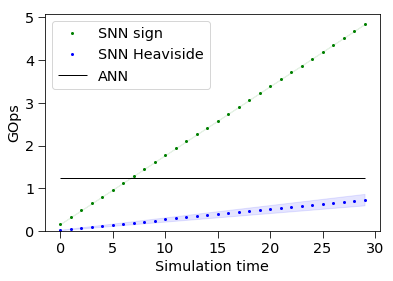

In [21]:
for exp in experiments:
    plt.plot(exp.time, exp.mean_computations_t, exp.marker, color=exp.color1, markersize=exp.markersize, label=exp.label)
    plt.fill_between(exp.time, exp.mean_computations_t-exp.std_computations_t, exp.mean_computations_t+exp.std_computations_t, alpha=0.1, color=exp.color1)
plt.hlines(c_ANN, 0, experiments[0].time[-1], linewidth=1, label='ANN')
plt.ylabel('GOps')
plt.xlabel('Simulation time')
plt.legend()
plt.ylim(0, None)
plt.savefig(os.path.join(log_dir, 'ops_vs_t'), bbox_inches='tight')

## Plot error vs time

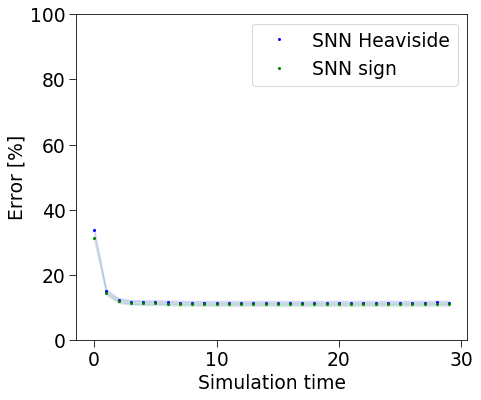

In [6]:
for exp in experiments:
    plt.plot(exp.time, exp.e1_mean, exp.marker, color=exp.color1, markersize=exp.markersize, label=exp.label)
    plt.fill_between(exp.time, exp.e1_mean-exp.e1_confidence95, exp.e1_mean+exp.e1_confidence95, alpha=0.1, color=exp.color1)
plt.ylabel('Error [%]')
plt.xlabel('Simulation time')
plt.ylim(0, 100)
plt.legend()
plt.savefig(os.path.join(log_dir, 'err_vs_t'), bbox_inches='tight')

## Plot error vs operations

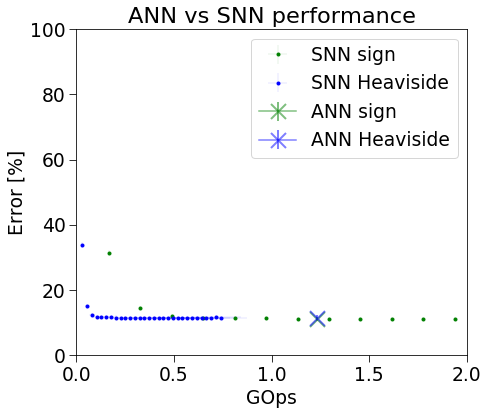

In [13]:
show_numbers = False

for exp in experiments:
    plt.errorbar(exp.mean_computations_t, exp.e1_mean, xerr=exp.std_computations_t,
                 yerr=exp.e1_confidence95, fmt=exp.marker, label='SNN '+exp.label, capsize=0, elinewidth=0.1, color=exp.color1)

exp = experiments[0]
plt.errorbar(exp.operations_ann, exp.e1_ann, marker='x', label='ANN '+exp.label, color=exp.color1, markersize=15,
             yerr=exp.e1_confidence95_ann, elinewidth=2, capthick=2, markeredgewidth=2, alpha=0.5)
if show_numbers:
    plt.annotate('({:.2f}, {:.2f})'.format(exp.operations_ann, exp.e1_ann), xy=(exp.operations_ann - 0.15, exp.e1_ann + 10), color=exp.color1)
    plt.annotate('({:.2f}, {:.2f})'.format(exp.op1_optimal, exp.e1_optimal), xy=(exp.op1_optimal, exp.e1_optimal),
                 xytext=(exp.op1_optimal, exp.e1_optimal + 10),
                 arrowprops=dict(color=exp.color1, shrink=0.05, width=5, headwidth=10), color=exp.color1)

exp = experiments[1]
plt.errorbar(exp.operations_ann, exp.e1_ann, marker='x', label='ANN '+exp.label, color=exp.color1, markersize=15,
             yerr=exp.e1_confidence95_ann, elinewidth=2, capthick=2, markeredgewidth=2, alpha=0.5)
if show_numbers:
    plt.annotate('({:.2f}, {:.2f})'.format(exp.operations_ann, exp.e1_ann), xy=(exp.operations_ann - 0.15, exp.e1_ann - 10), color=exp.color1)
    plt.annotate('({:.2f}, {:.2f})'.format(exp.op1_optimal, exp.e1_optimal), xy=(exp.op1_optimal, exp.e1_optimal),
                 xytext=(exp.op1_optimal, exp.e1_optimal - 10),
                 arrowprops=dict(color=exp.color1, shrink=0.05, width=5, headwidth=10), color=exp.color1)

plt.xlim(0, 2)
plt.ylim(0, 100)
plt.ylabel('Error [%]')
plt.xlabel('GOps')
plt.legend(loc='upper right')
plt.title('ANN vs SNN performance')
plt.savefig(os.path.join(log_dir, 'err_vs_ops'), bbox_inches='tight')

In [12]:
for exp in experiments:
    print('SNN {}: ({:.2f} MOps/frame, {:.2f} %)'.format(exp.label, exp.op1_optimal, exp.e1_optimal))
    print('ANN {}: ({:.2f} MOps/frame, {:.2f} %)'.format(exp.label, exp.operations_ann, exp.e1_ann))

AttributeError: 'ExpResults' object has no attribute 'op1_optimal'